In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing required libraries

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
import scipy.stats as stats

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [3]:
pd.set_option('display.max_columns', None)

# Merging all datasets

In [4]:
old_path = os.getcwd()

file_names = []

# Iterating through the directories
for folder in os.listdir():
    
    # Iterating through only folders and ignoring hidden files if any
    if os.path.isdir(folder) and not folder.startswith('.'):
        
        # Changing the directory to get the files
        os.chdir(folder)
        
        try:
            # Importing all files
            for file in os.listdir():
                file_names.append(folder + '/' + file)
                
        except:
            print('Error Occured while importing: {} file'.format(file))
            os.chdir(old_path)
        
        # Returning the parent directory
        os.chdir(old_path)

# To store dataframes
dataframes = {}

for file_name in file_names:
    dataframes[file_name.split(".")[0]] = pd.read_csv(os.getcwd() + '/' + file_name, skiprows = 2)
    
dataset = None

# Merging all dataframes excluding few columns to aviod duplicate columns
for df_name, df in dataframes.items():
    columns_to_exclude = ['Year', 'County', 'State', 'Diagnosed Diabetes Percentage']
    columns_to_merge = [col for col in df.columns if col not in columns_to_exclude]

    if dataset is None:
        dataset = df[columns_to_merge]
        
    else:
        dataset = pd.merge(dataset, df[columns_to_merge], on = 'County_FIPS', how = 'inner', suffixes = ('', '_remove'))
    
# To drop last row
dataset = dataset[:-1]

In [5]:
# Changing the directory to grab obesity, inactivity, and diabetes files
os.chdir('/Users/neereshkumarperla/Documents/NeereshMaster/Assignments/MTH 522 - Advance Mathematical Statistics')

obesity = pd.read_excel('cdc-diabetes-2018.xlsx', sheet_name = 'Obesity')
obesity.drop(['YEAR'], axis = 1, inplace = True)

inactivity = pd.read_excel('cdc-diabetes-2018.xlsx', sheet_name = 'Inactivity')
inactivity.rename(columns = {'FIPDS': 'FIPS'}, inplace = True)
inactivity.drop(['YEAR'], axis = 1, inplace = True)

diabetes = pd.read_excel('cdc-diabetes-2018.xlsx', sheet_name = 'Diabetes')
diabetes.drop(['YEAR'], axis = 1, inplace = True)

# Changing the directory to project directory
os.chdir(old_path)

common_column = 'FIPS'

temp_dataset = pd.merge(obesity, inactivity, on=common_column, how='inner', suffixes= ('', '_remove'))
temp_dataset = pd.merge(temp_dataset, diabetes, on=common_column, how='inner', suffixes= ('', '_remove'))

# Removing the duplicate columns
columns_to_remove = [column for column in dataset.columns if '_remove' in column]
dataset.drop(columns_to_remove, axis = 1, inplace = True)

columns_to_remove = [column for column in temp_dataset.columns if '_remove' in column]
temp_dataset.drop(columns_to_remove, axis = 1, inplace = True)
temp_dataset.drop(['STATEW'], axis = 1, inplace = True)

# Renaming the FIPS to County_FIPS to merge the datasets: temp_dataset and dataset
temp_dataset.rename(columns = {'FIPS': 'County_FIPS'}, inplace = True)
temp_dataset['County_FIPS'] = temp_dataset['County_FIPS'].astype('float64')

# This will be our final dataset to perform analysis
final_dataset = pd.merge(temp_dataset, dataset, on = 'County_FIPS', how = 'inner')

final_dataset

,County_FIPS,COUNTY,STATE,% OBESE,% INACTIVE,% DIABETIC,Urban_Rural,Overall SVI,No Health Insurance,Dentists per 100000 Population,Primary Care Physicians per 100000 Population,Number of Primary Care Physicians,Number of Dentists,Commute ≥ 60 min,Single-Parent Households,Overall Minority Status & Language,Unemployed,Group Quarters,No Vehicle,Below Poverty,Civilian with a Disability,Mobile Homes,Aged 17 or Younger,Crowding,Minority,Multi-Unit Structures,Overall Household Composition & Disability,Aged 65 or Older,Income Vulnerability,Overall Socioeconomic Status,Speaks English 'Less than Well',No High School Diploma,Access to Exercise Opportunities,Enrolled in Free or Reduced Lunch,Food Environment Index,Food Insecurity,Limited Access To Healthy Foods,Severe Housing Cost Burden,Children in Poverty,Household with No Internet Service
0,1011.0,Bullock County,Alabama,18.7,17.0,9.4,Rural,0.8898,11.4,20.04812,29.70003,3,2,11.9,0.9955,0.6749,0.9599,0.7689,0.9500,0.9777,0.3983,0.9637,0.2967,0.0000,0.9809,0.3200,0.4438,0.2572,0.8924,0.9771,0.2970,0.9491,1.878321422,75.462645648,4.6,15.7,32.339190387,12.759643917,38.7,30.7
1,2068.0,Denali Borough,Alaska,18.9,16.2,6.8,Rural,0.101,18.5,No Data,No Data,No Data,No Data,6.3,0.0134,0.4540,0.1245,0.9971,0.1210,0.6443,0.3200,0.4390,0.0022,0.6049,0.5492,0.4448,0.0032,0.0022,0.0901,0.1561,0.3582,0.0010,44.359255203,1.2084592145,4.6,15.1,33.09144787,7.2135785007,7.2,6.2
2,2105.0,Hoonah-Angoon Census Area,Alaska,19.4,15.0,7.3,Rural,0.4178,24.7,No Data,No Data,No Data,No Data,2.5,0.4330,0.4575,0.9561,0.8822,0.9946,0.1675,0.5005,0.2569,0.0210,0.8198,0.9124,0.0844,0.2139,0.6428,0.0844,0.3344,0.0000,0.2305,No Data,62.711864407,4.8,14.9,31.130174061,6.432748538,23.2,33.9
3,2195.0,Petersburg Census Area,Alaska,17.2,17.8,9.2,Rural,0.665,9.6,91.01942,183.71096,6,3,0.7,0.5597,0.7657,0.2924,0.5769,0.9844,0.0882,0.7434,0.4830,0.5151,0.7622,0.7711,0.6399,0.8927,0.7947,0.1344,0.1643,0.6558,0.3709,No Data,56.076759062,8.3,12.7,0.6674929034,10.127659574,9.4,15.6
4,2230.0,Skagway Municipality,Alaska,18.3,15.8,6.6,Rural,0.1685,18.2,No Data,No Data,No Data,No Data,0.3,0.2961,0.3919,0.7092,0.9647,0.7685,0.0146,0.1184,0.3916,0.0646,0.8348,0.5043,0.1512,0.0099,0.0423,0.0408,0.1532,0.2970,0.0834,100,2.1428571429,8.2,13.4,0.0599157949,1.5831134565,5,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,51820.0,Waynesboro City,Virginia,19.5,16.6,8.6,Urban,0.6013,13.6,118.72829000000002,97.21607999999999,22,27,3.7,0.8809,0.6587,0.3299,0.0936,0.8201,0.6745,0.4250,0.0831,0.6291,0.3359,0.6224,0.8548,0.8278,0.5215,0.5605,0.5513,0.6310,0.5715,72.779205941,60.857818305,7.5,13.1,7.9537350719,15.561893896,18.9,23.6
350,51830.0,Williamsburg City,Virginia,18.0,15.7,8.5,Urban,0.385,5.9,No Data,13.37435,2,No Data,6.6,0.4330,0.4782,0.7895,0.9936,0.8571,0.8627,0.1038,0.0000,0.0019,0.3359,0.7122,0.9787,0.0204,0.1974,0.2959,0.4997,0.2270,0.0201,99.502416833,41.746411483,7.9,12.3,5.641509498,15.206536541,20,7.9
351,51840.0,Winchester City,Virginia,19.4,16.1,6.9,Urban,0.722,13.8,198.55595999999997,252.86701,71,55,14.4,0.8628,0.8816,0.2188,0.7335,0.8529,0.5127,0.4352,0.0137,0.5715,0.6622,0.7291,0.9058,0.5969,0.2572,0.2694,0.429,0.9287,0.7383,100,63.767565515,7.9,13.1,4.3648085751,12.161515644,18.8,18.7
352,53055.0,San Juan County,Washington,19.3,11.9,4.5,Rural,0.0863,6.4,68.60279,79.62689,14,12,4.7,0.1102,0.4454,0.1245,0.2184,0.2420,0.2704,0.1840,0.2346,0.0080,0.8198,0.3811,0.4317,0.0930,0.9911,0.0274,0.0404,0.5113,0.0150,80.867524891,36.965811966,No Data,9.8,No Data,15.825254941,11,8.6


In [6]:
# Checking if we have any null values after all merging
final_dataset.isnull().any().sum()

0

# Handling Missing Data

## Replacing "No Data" with np.nan

In [7]:
final_dataset.head()

,County_FIPS,COUNTY,STATE,% OBESE,% INACTIVE,% DIABETIC,Urban_Rural,Overall SVI,No Health Insurance,Dentists per 100000 Population,Primary Care Physicians per 100000 Population,Number of Primary Care Physicians,Number of Dentists,Commute ≥ 60 min,Single-Parent Households,Overall Minority Status & Language,Unemployed,Group Quarters,No Vehicle,Below Poverty,Civilian with a Disability,Mobile Homes,Aged 17 or Younger,Crowding,Minority,Multi-Unit Structures,Overall Household Composition & Disability,Aged 65 or Older,Income Vulnerability,Overall Socioeconomic Status,Speaks English 'Less than Well',No High School Diploma,Access to Exercise Opportunities,Enrolled in Free or Reduced Lunch,Food Environment Index,Food Insecurity,Limited Access To Healthy Foods,Severe Housing Cost Burden,Children in Poverty,Household with No Internet Service
0,1011.0,Bullock County,Alabama,18.7,17.0,9.4,Rural,0.8898,11.4,20.04812,29.70003,3,2,11.9,0.9955,0.6749,0.9599,0.7689,0.9500,0.9777,0.3983,0.9637,0.2967,0.0000,0.9809,0.3200,0.4438,0.2572,0.8924,0.9771,0.2970,0.9491,1.878321422,75.462645648,4.6,15.7,32.339190387,12.759643917,38.7,30.7
1,2068.0,Denali Borough,Alaska,18.9,16.2,6.8,Rural,0.101,18.5,No Data,No Data,No Data,No Data,6.3,0.0134,0.4540,0.1245,0.9971,0.1210,0.6443,0.3200,0.4390,0.0022,0.6049,0.5492,0.4448,0.0032,0.0022,0.0901,0.1561,0.3582,0.0010,44.359255203,1.2084592145,4.6,15.1,33.09144787,7.2135785007,7.2,6.2
2,2105.0,Hoonah-Angoon Census Area,Alaska,19.4,15.0,7.3,Rural,0.4178,24.7,No Data,No Data,No Data,No Data,2.5,0.4330,0.4575,0.9561,0.8822,0.9946,0.1675,0.5005,0.2569,0.0210,0.8198,0.9124,0.0844,0.2139,0.6428,0.0844,0.3344,0.0000,0.2305,No Data,62.711864407,4.8,14.9,31.130174061,6.432748538,23.2,33.9
3,2195.0,Petersburg Census Area,Alaska,17.2,17.8,9.2,Rural,0.665,9.6,91.01942,183.71096,6,3,0.7,0.5597,0.7657,0.2924,0.5769,0.9844,0.0882,0.7434,0.4830,0.5151,0.7622,0.7711,0.6399,0.8927,0.7947,0.1344,0.1643,0.6558,0.3709,No Data,56.076759062,8.3,12.7,0.6674929034,10.127659574,9.4,15.6
4,2230.0,Skagway Municipality,Alaska,18.3,15.8,6.6,Rural,0.1685,18.2,No Data,No Data,No Data,No Data,0.3,0.2961,0.3919,0.7092,0.9647,0.7685,0.0146,0.1184,0.3916,0.0646,0.8348,0.5043,0.1512,0.0099,0.0423,0.0408,0.1532,0.2970,0.0834,100,2.1428571429,8.2,13.4,0.0599157949,1.5831134565,5,12.5


In [8]:
# Number of rows that are having "No Data" 
no_data_rows = (final_dataset == "No Data").any(axis = 0)

dataframe_with_missing_data = final_dataset.loc[:, no_data_rows]
no_data_columns = dataframe_with_missing_data.columns

dataframe_with_missing_data.head()

,No Health Insurance,Dentists per 100000 Population,Primary Care Physicians per 100000 Population,Number of Primary Care Physicians,Number of Dentists,Commute ≥ 60 min,Access to Exercise Opportunities,Enrolled in Free or Reduced Lunch,Food Environment Index,Limited Access To Healthy Foods,Severe Housing Cost Burden,Children in Poverty
0,11.4,20.04812,29.70003,3,2,11.9,1.878321422,75.462645648,4.6,32.339190387,12.759643917,38.7
1,18.5,No Data,No Data,No Data,No Data,6.3,44.359255203,1.2084592145,4.6,33.09144787,7.2135785007,7.2
2,24.7,No Data,No Data,No Data,No Data,2.5,No Data,62.711864407,4.8,31.130174061,6.432748538,23.2
3,9.6,91.01942,183.71096,6,3,0.7,No Data,56.076759062,8.3,0.6674929034,10.127659574,9.4
4,18.2,No Data,No Data,No Data,No Data,0.3,100,2.1428571429,8.2,0.0599157949,1.5831134565,5


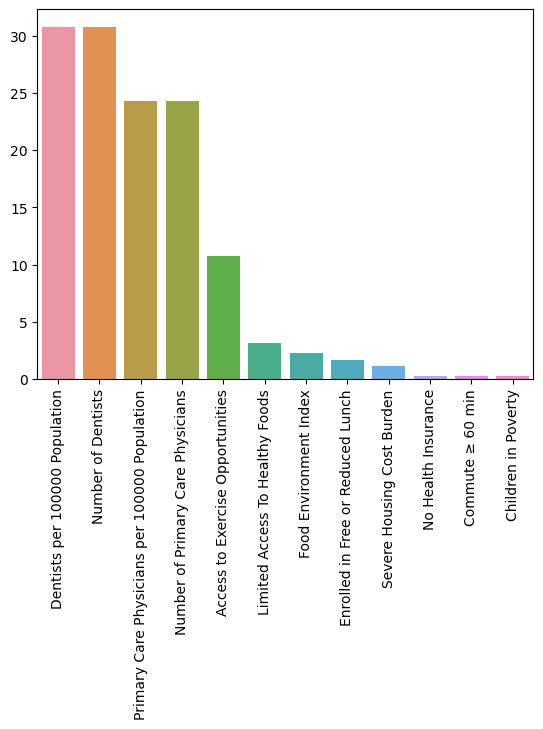

In [9]:
final_dataset = final_dataset.replace("No Data", np.nan)

missing_values = final_dataset[no_data_columns].isnull().sum().sort_values(ascending = False) / len(final_dataset) * 100

sns.barplot(x = list(missing_values.index), y = missing_values.values)
plt.xticks(rotation = 90)

plt.show()

In [10]:
final_dataset.columns

Index(['County_FIPS', 'COUNTY', 'STATE', '% OBESE', '% INACTIVE', '% DIABETIC',
       'Urban_Rural', 'Overall SVI', 'No Health Insurance',
       'Dentists per 100000 Population',
       'Primary Care Physicians per 100000 Population',
       'Number of Primary Care Physicians', 'Number of Dentists',
       'Commute ≥ 60 min', 'Single-Parent Households',
       'Overall Minority Status & Language', 'Unemployed', 'Group Quarters',
       'No Vehicle', 'Below Poverty', 'Civilian with a Disability',
       'Mobile Homes', 'Aged 17 or Younger', 'Crowding', 'Minority',
       'Multi-Unit Structures', 'Overall Household Composition & Disability',
       'Aged 65 or Older', 'Income Vulnerability',
       'Overall Socioeconomic Status', 'Speaks English 'Less than Well'',
       'No High School Diploma', 'Access to Exercise Opportunities',
       'Enrolled in Free or Reduced Lunch', 'Food Environment Index',
       'Food Insecurity', 'Limited Access To Healthy Foods',
       'Severe Housing Co

## Data type conversions

In [11]:
categorical_features = ['COUNTY', 'STATE', 'Urban_Rural']
numerical_features = [feature for feature in final_dataset.columns if feature not in categorical_features]

final_dataset.head()

,County_FIPS,COUNTY,STATE,% OBESE,% INACTIVE,% DIABETIC,Urban_Rural,Overall SVI,No Health Insurance,Dentists per 100000 Population,Primary Care Physicians per 100000 Population,Number of Primary Care Physicians,Number of Dentists,Commute ≥ 60 min,Single-Parent Households,Overall Minority Status & Language,Unemployed,Group Quarters,No Vehicle,Below Poverty,Civilian with a Disability,Mobile Homes,Aged 17 or Younger,Crowding,Minority,Multi-Unit Structures,Overall Household Composition & Disability,Aged 65 or Older,Income Vulnerability,Overall Socioeconomic Status,Speaks English 'Less than Well',No High School Diploma,Access to Exercise Opportunities,Enrolled in Free or Reduced Lunch,Food Environment Index,Food Insecurity,Limited Access To Healthy Foods,Severe Housing Cost Burden,Children in Poverty,Household with No Internet Service
0,1011.0,Bullock County,Alabama,18.7,17.0,9.4,Rural,0.8898,11.4,20.04812,29.70003,3,2,11.9,0.9955,0.6749,0.9599,0.7689,0.9500,0.9777,0.3983,0.9637,0.2967,0.0000,0.9809,0.3200,0.4438,0.2572,0.8924,0.9771,0.2970,0.9491,1.878321422,75.462645648,4.6,15.7,32.339190387,12.759643917,38.7,30.7
1,2068.0,Denali Borough,Alaska,18.9,16.2,6.8,Rural,0.101,18.5,NaN,NaN,NaN,NaN,6.3,0.0134,0.4540,0.1245,0.9971,0.1210,0.6443,0.3200,0.4390,0.0022,0.6049,0.5492,0.4448,0.0032,0.0022,0.0901,0.1561,0.3582,0.0010,44.359255203,1.2084592145,4.6,15.1,33.09144787,7.2135785007,7.2,6.2
2,2105.0,Hoonah-Angoon Census Area,Alaska,19.4,15.0,7.3,Rural,0.4178,24.7,NaN,NaN,NaN,NaN,2.5,0.4330,0.4575,0.9561,0.8822,0.9946,0.1675,0.5005,0.2569,0.0210,0.8198,0.9124,0.0844,0.2139,0.6428,0.0844,0.3344,0.0000,0.2305,NaN,62.711864407,4.8,14.9,31.130174061,6.432748538,23.2,33.9
3,2195.0,Petersburg Census Area,Alaska,17.2,17.8,9.2,Rural,0.665,9.6,91.01942,183.71096,6,3,0.7,0.5597,0.7657,0.2924,0.5769,0.9844,0.0882,0.7434,0.4830,0.5151,0.7622,0.7711,0.6399,0.8927,0.7947,0.1344,0.1643,0.6558,0.3709,NaN,56.076759062,8.3,12.7,0.6674929034,10.127659574,9.4,15.6
4,2230.0,Skagway Municipality,Alaska,18.3,15.8,6.6,Rural,0.1685,18.2,NaN,NaN,NaN,NaN,0.3,0.2961,0.3919,0.7092,0.9647,0.7685,0.0146,0.1184,0.3916,0.0646,0.8348,0.5043,0.1512,0.0099,0.0423,0.0408,0.1532,0.2970,0.0834,100,2.1428571429,8.2,13.4,0.0599157949,1.5831134565,5,12.5


In [12]:
final_dataset[numerical_features] = final_dataset[numerical_features].astype('float')
final_dataset[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   County_FIPS                                    354 non-null    float64
 1   % OBESE                                        354 non-null    float64
 2   % INACTIVE                                     354 non-null    float64
 3   % DIABETIC                                     354 non-null    float64
 4   Overall SVI                                    354 non-null    float64
 5   No Health Insurance                            353 non-null    float64
 6   Dentists per 100000 Population                 245 non-null    float64
 7   Primary Care Physicians per 100000 Population  268 non-null    float64
 8   Number of Primary Care Physicians              268 non-null    float64
 9   Number of Dentists                             245 non

## Economical Factors

In [13]:
final_dataset.columns

Index(['County_FIPS', 'COUNTY', 'STATE', '% OBESE', '% INACTIVE', '% DIABETIC',
       'Urban_Rural', 'Overall SVI', 'No Health Insurance',
       'Dentists per 100000 Population',
       'Primary Care Physicians per 100000 Population',
       'Number of Primary Care Physicians', 'Number of Dentists',
       'Commute ≥ 60 min', 'Single-Parent Households',
       'Overall Minority Status & Language', 'Unemployed', 'Group Quarters',
       'No Vehicle', 'Below Poverty', 'Civilian with a Disability',
       'Mobile Homes', 'Aged 17 or Younger', 'Crowding', 'Minority',
       'Multi-Unit Structures', 'Overall Household Composition & Disability',
       'Aged 65 or Older', 'Income Vulnerability',
       'Overall Socioeconomic Status', 'Speaks English 'Less than Well'',
       'No High School Diploma', 'Access to Exercise Opportunities',
       'Enrolled in Free or Reduced Lunch', 'Food Environment Index',
       'Food Insecurity', 'Limited Access To Healthy Foods',
       'Severe Housing Co

In [14]:
temp_dataset = final_dataset[['Children in Poverty', 'Household with No Internet Service', 'Severe Housing Cost Burden',
                             'Urban_Rural', '% OBESE', '% INACTIVE', '% DIABETIC']]

numerical_features = [feature for feature in temp_dataset.columns if temp_dataset[feature].dtype != 'object']
temp_dataset.head()

,Children in Poverty,Household with No Internet Service,Severe Housing Cost Burden,Urban_Rural,% OBESE,% INACTIVE,% DIABETIC
0,38.7,30.7,12.759644,Rural,18.7,17.0,9.4
1,7.2,6.2,7.213579,Rural,18.9,16.2,6.8
2,23.2,33.9,6.432749,Rural,19.4,15.0,7.3
3,9.4,15.6,10.127660,Rural,17.2,17.8,9.2
4,5.0,12.5,1.583113,Rural,18.3,15.8,6.6


## Descriptive Statistics

In [15]:
temp_dataset.describe()

,Children in Poverty,Household with No Internet Service,Severe Housing Cost Burden,% OBESE,% INACTIVE,% DIABETIC
count,353.000000,354.000000,350.000000,354.000000,354.000000,354.000000
mean,20.829178,23.874859,10.176455,18.252542,14.776271,7.115819
std,9.123560,9.935686,4.134580,1.029484,1.544542,0.728442
min,2.600000,2.500000,1.172161,10.500000,8.800000,3.800000
25%,14.600000,17.600000,7.265389,17.900000,14.000000,6.800000
50%,20.000000,23.300000,9.726930,18.300000,14.400000,7.000000
75%,26.600000,29.300000,12.435594,18.975000,15.475000,7.400000
max,59.700000,58.700000,25.555556,19.500000,19.400000,9.700000


Percentage of missing values:
Severe Housing Cost Burden    1.129944
Children in Poverty           0.282486
dtype: float64


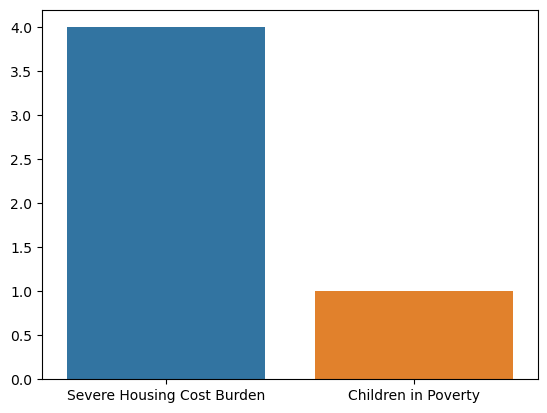

In [16]:
null_columns = [feature for feature in temp_dataset.columns if temp_dataset[feature].isnull().sum() > 0]
missing_values = temp_dataset[null_columns].isnull().sum().sort_values(ascending = False)

print('Percentage of missing values:')
print(temp_dataset[null_columns].isnull().sum().sort_values(ascending = False) / len(temp_dataset) * 100)

sns.barplot(x = list(missing_values.index), y = missing_values.values)

plt.show()

**Since there are very less null rows, we can remove them.**

In [17]:
null_rows = temp_dataset[temp_dataset.isnull().any(axis = 1)]

null_rows

,Children in Poverty,Household with No Internet Service,Severe Housing Cost Burden,Urban_Rural,% OBESE,% INACTIVE,% DIABETIC
79,NaN,28.2,NaN,Urban,17.6,15.2,8.4
196,8.5,16.3,NaN,Rural,17.9,13.8,7.1
262,13.8,51.8,NaN,Urban,17.9,14.0,6.9
276,11.3,26.7,NaN,Rural,18.5,14.3,7.2


### Dropping Null Values

In [18]:
temp_dataset = temp_dataset.dropna()

### Histrogram

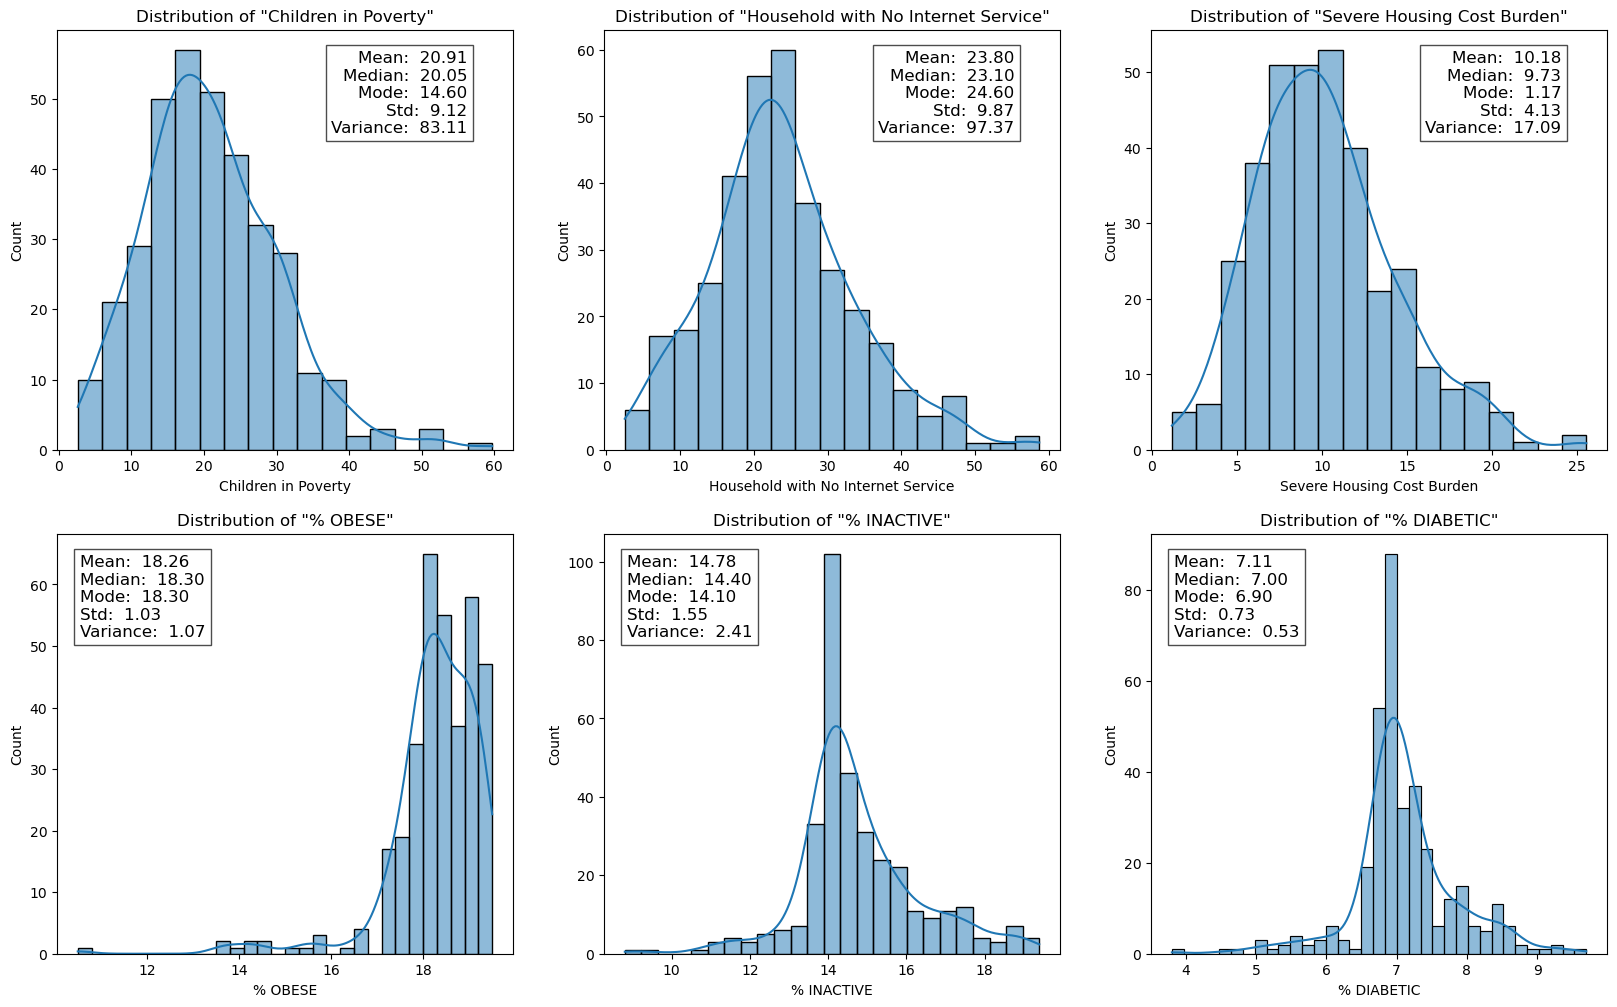

In [19]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(20, 12))

row, col = 0, 0
for feature in numerical_features:
    
    mean = temp_dataset[feature].mean()
    median = temp_dataset[feature].median()
    mode = temp_dataset[feature].mode().values[0]
    std = temp_dataset[feature].std()
    variance = temp_dataset[feature].var()
    
    sns.histplot(temp_dataset[feature], ax = ax[row, col], kde=True)
    ax[row, col].set_title('Distribution of "{}"'.format(feature))
    
    stats_text = f"Mean: {mean: .2f}\nMedian: {median: .2f}\nMode: {mode: .2f}\nStd: {std: .2f}\nVariance: {variance: .2f}"
    
    if row == 0:
        ax[row, col].text(
            0.9, 0.95, stats_text, transform = ax[row, col].transAxes, 
            fontsize = 12, horizontalalignment = 'right', verticalalignment = 'top', bbox = dict(facecolor = 'white', alpha = 0.7))
    else:
        ax[row, col].text(
            0.05, 0.95, stats_text, transform = ax[row, col].transAxes, 
            fontsize = 12, horizontalalignment = 'left', verticalalignment = 'top', bbox = dict(facecolor = 'white', alpha = 0.7))
    
    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0
        
plt.show()

**As we can see that, only "% INACTIVE" and "% DIABETIC" are close to normal distribution.**<br>
**Features such as "Children in Poverty", "Household with No Internet Service", and "Severe Housing Cost Burden" are slightly right skewed.**<br>
**"% OBESE" is extremely left skewed.**

**We can further check how these features vary when compared to normal distribution using Q-Q Plots.**

### Q-Q Plots

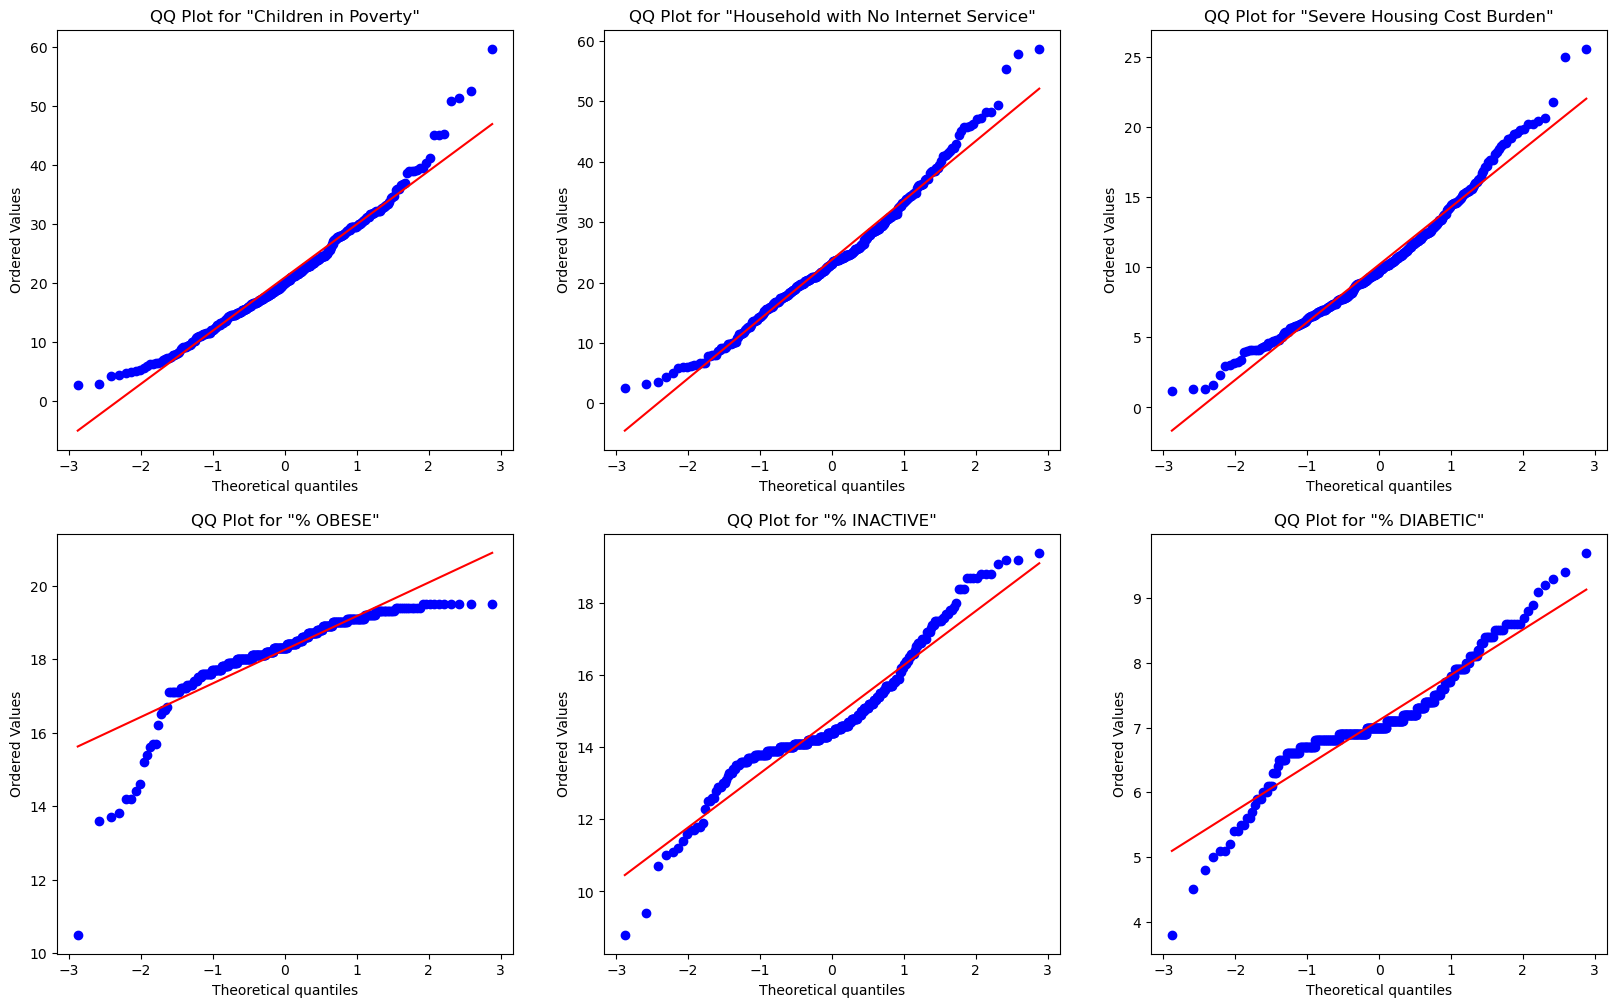

In [20]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(20, 12))

row, col = 0, 0
for feature in numerical_features:

    stats.probplot(temp_dataset[feature], dist = "norm", plot = ax[row, col])
    ax[row, col].set_title(f'QQ Plot for "{feature}"')

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

**For some of these plot we cannot see the diagonal line because that thefeature do not follow a normal distribution. Some reasons would be data has non-normal distribution, presence of outliers, due to small sample size, etc.**

**If we want to use this feature for analysis that assumes normality, we should apply data transformation techniques or applying statistical methods that are robust to non-normality.**

### Boxplots

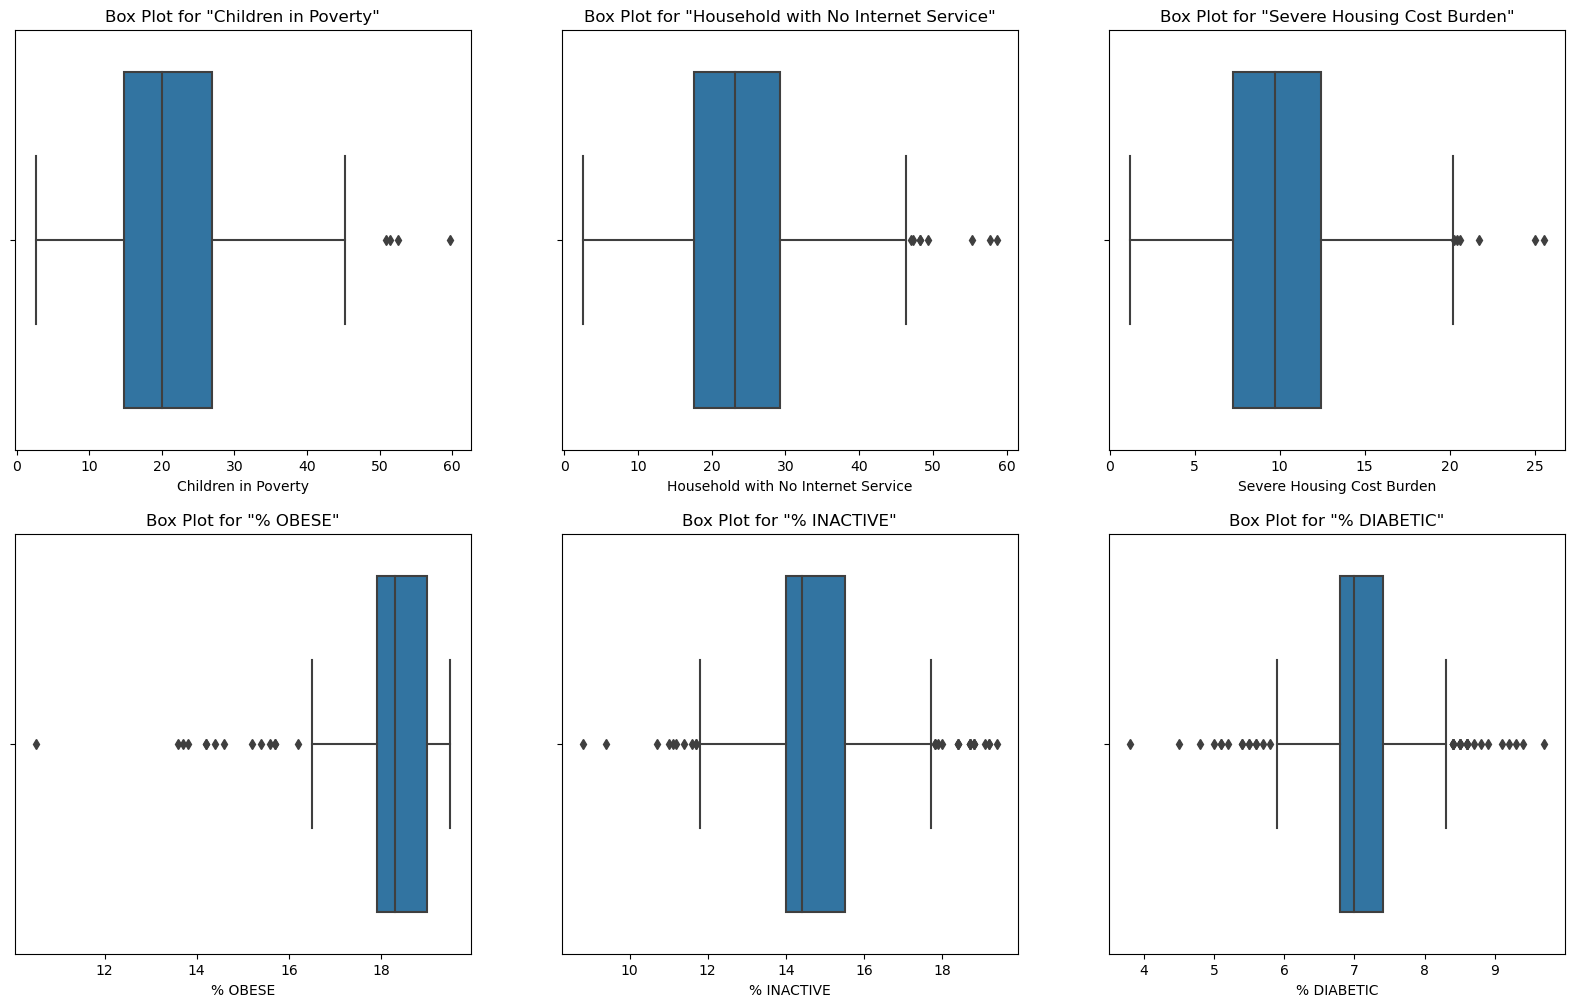

In [21]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(20, 12))

row, col = 0, 0
for feature in numerical_features:
    
    sns.boxplot(x = temp_dataset[feature], ax = ax[row, col])
    ax[row, col].set_title(f'Box Plot for "{feature}"')

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

**There are outliers in every feature. In the previous block of code we saw that the normality line (diagonal line) was missing for "Children in Poverty" and "Severe Housing Cost Burden".**

**We can apply data transformation to reduce outliers.**

### Boxplots (Outliers Removed)

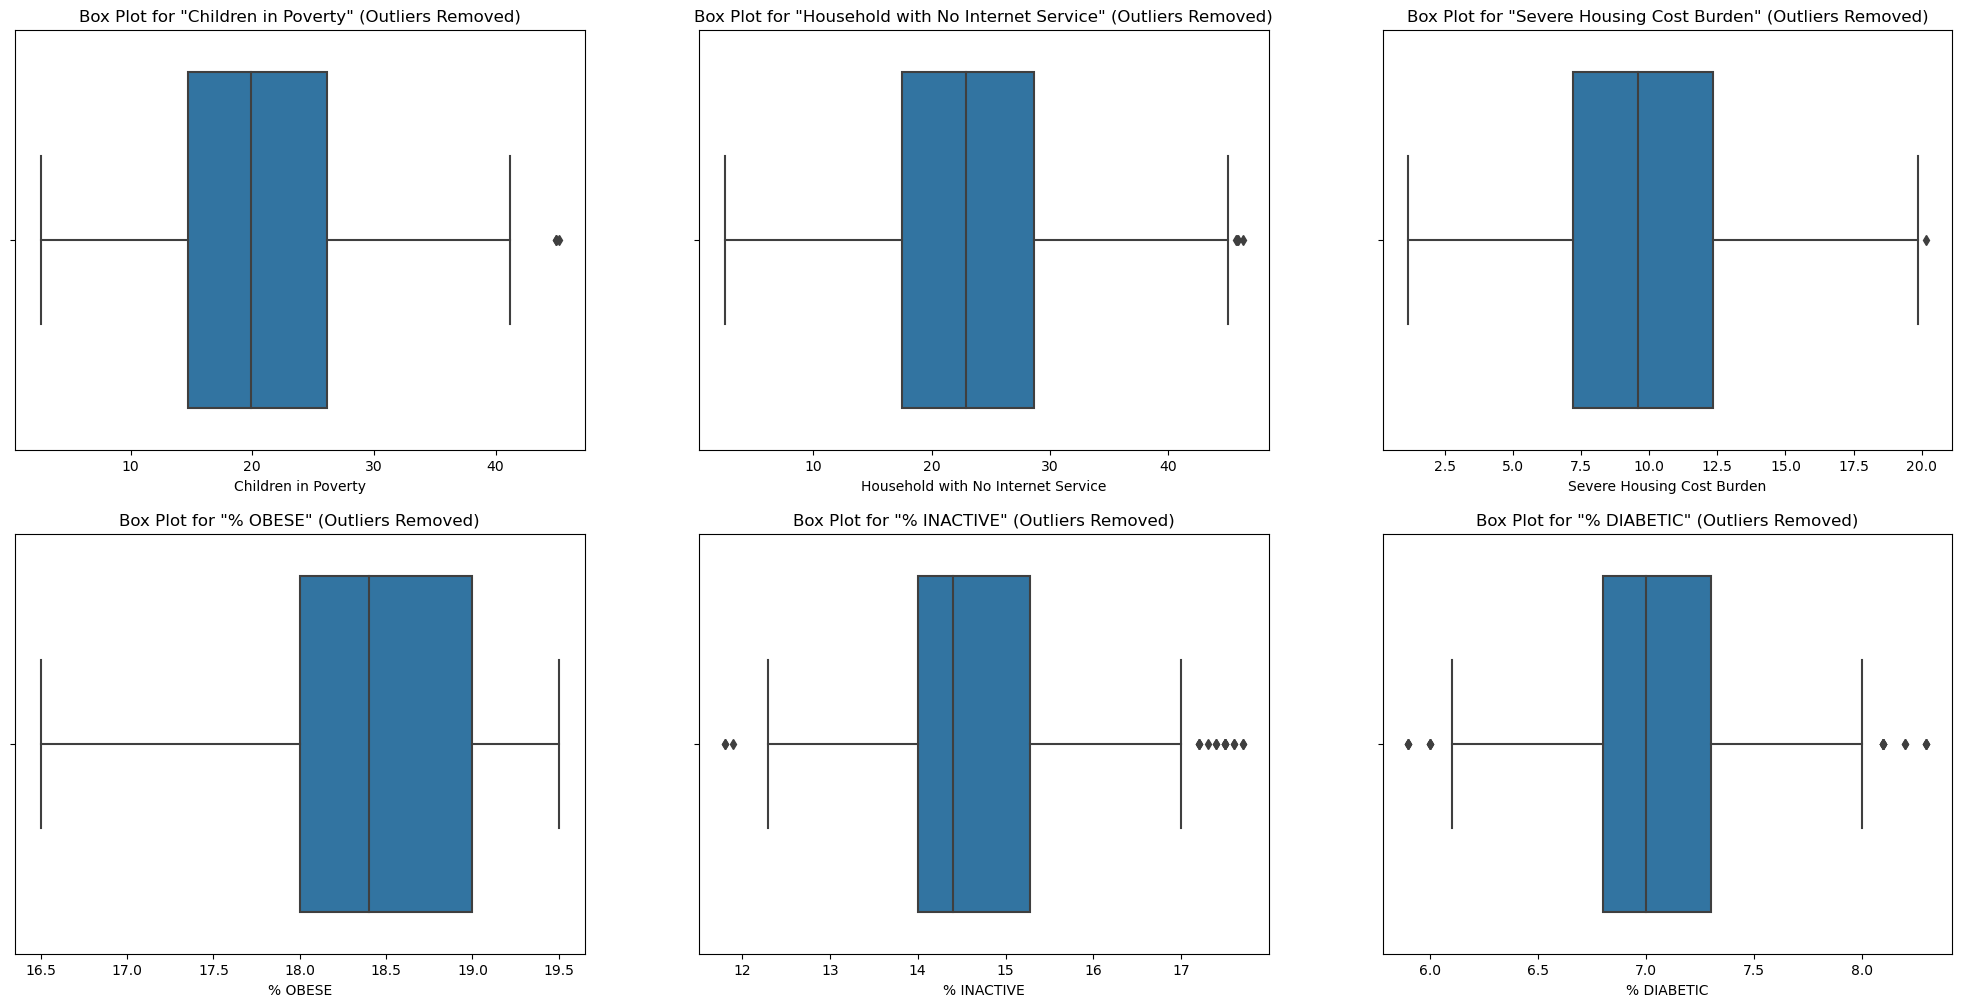

In [22]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(25, 12))

row, col = 0, 0
for feature in numerical_features:
    
    Q1 = temp_dataset[feature].quantile(0.25)
    Q3 = temp_dataset[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_no_outliers = temp_dataset[(temp_dataset[feature] >= lower_bound) & (temp_dataset[feature] <= upper_bound)]

    sns.boxplot(x = data_no_outliers[feature], ax = ax[row, col])
    ax[row, col].set_title(f'Box Plot for "{feature}" (Outliers Removed)')

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

**In this part, I have used IQR method to reduce the outliers.**

### Q-Q Plot (Outliers Removed)

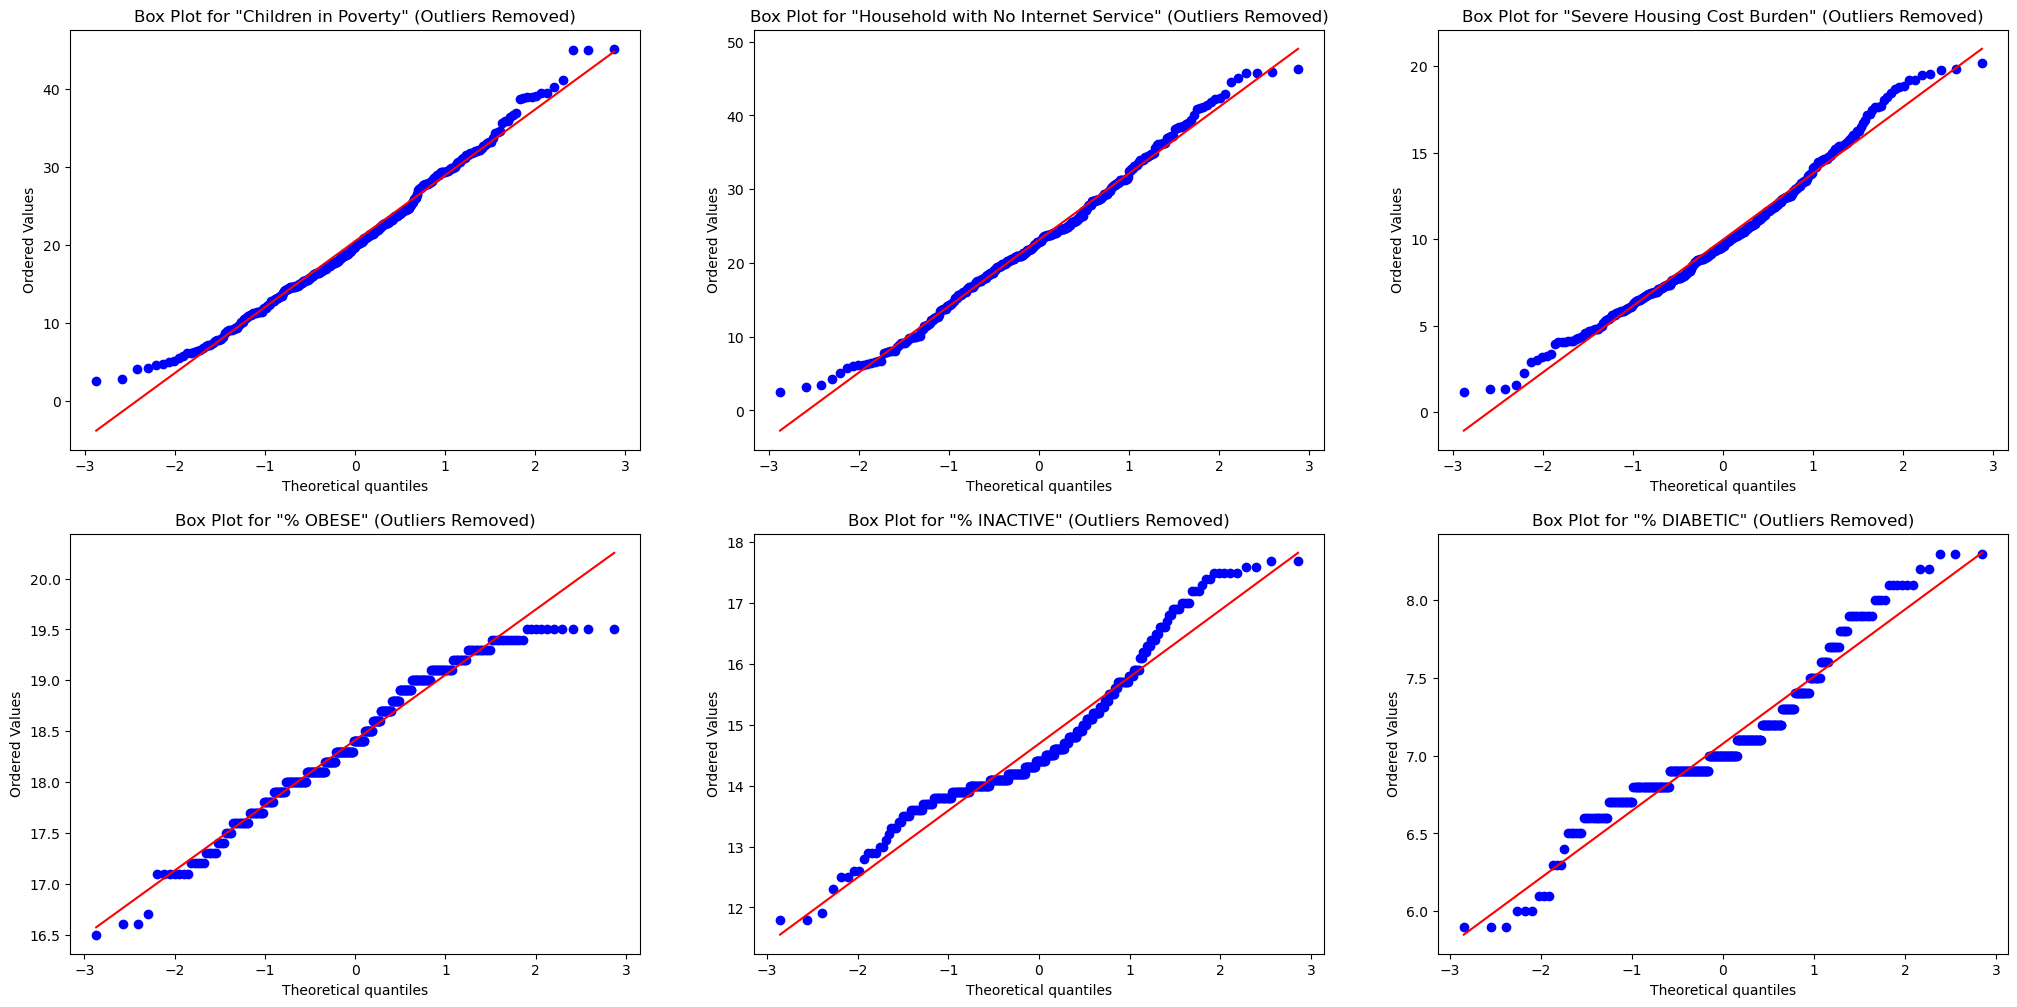

In [23]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(25, 12))

row, col = 0, 0
for feature in numerical_features:
    
    Q1 = temp_dataset[feature].quantile(0.25)
    Q3 = temp_dataset[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data_no_outliers = temp_dataset[(temp_dataset[feature] >= lower_bound) & (temp_dataset[feature] <= upper_bound)]

    stats.probplot(x = data_no_outliers[feature], dist = 'norm', plot = ax[row, col])
    ax[row, col].set_title(f'Box Plot for "{feature}" (Outliers Removed)')

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

**Now, we can see the normality line (diagonal line). So the presence of outliers were greatly impacting the feature's distribution.**<br>
**Almost all of the features are close to normal distributed.**

### Histograms (Outliers Removed)

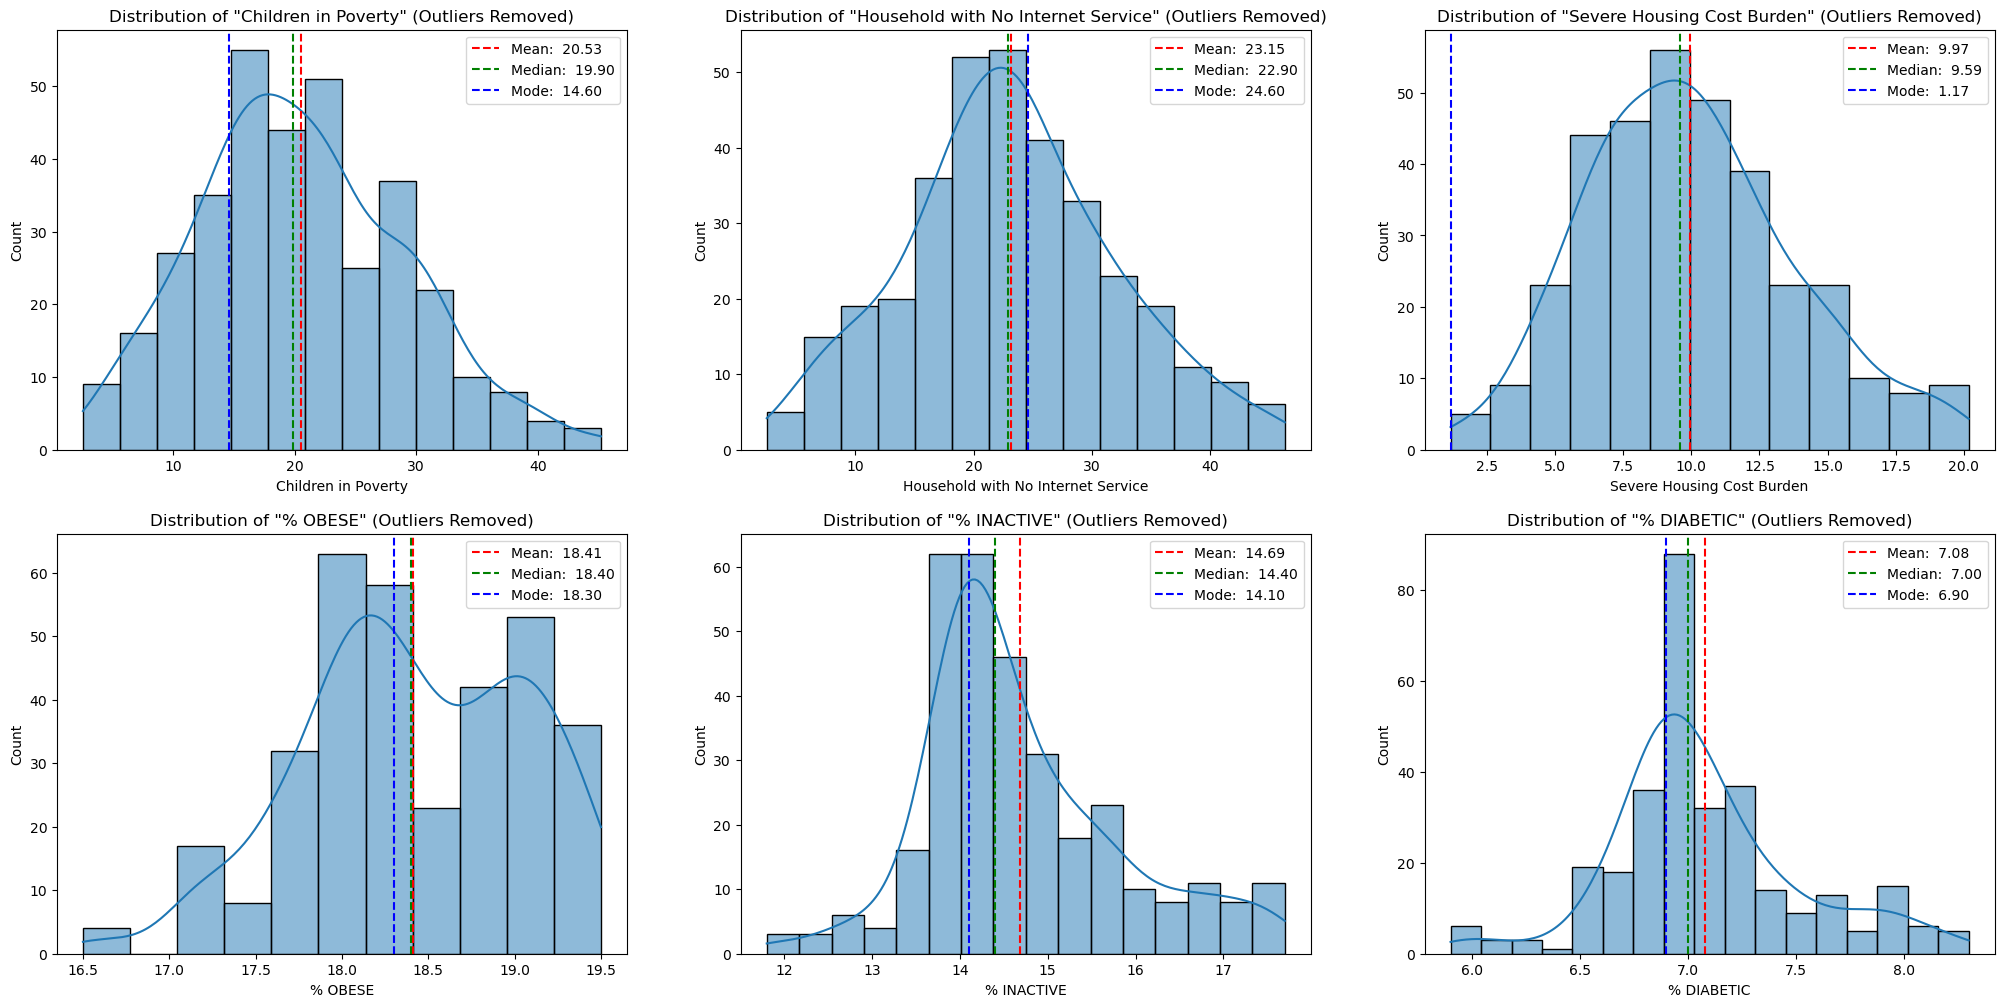

In [24]:
fig, ax = plt.subplots(2, int(len(numerical_features) / 2), figsize=(25, 12))

row, col = 0, 0
for feature in numerical_features:
    
    Q1 = temp_dataset[feature].quantile(0.25)
    Q3 = temp_dataset[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data_no_outliers = temp_dataset[(temp_dataset[feature] >= lower_bound) & (temp_dataset[feature] <= upper_bound)]
    
    sns.histplot(data_no_outliers[feature], ax = ax[row, col], kde = True)
    ax[row, col].set_title(f'Distribution of "{feature}" (Outliers Removed)')
    
    mean = data_no_outliers[feature].mean()
    median = data_no_outliers[feature].median()
    mode = data_no_outliers[feature].mode().values[0]

    ax[row, col].axvline(mean, color = 'r', linestyle = '--', label = f'Mean: {mean: .2f}')
    ax[row, col].axvline(median, color = 'g', linestyle = '--', label = f'Median: {median: .2f}')
    ax[row, col].axvline(mode, color = 'b', linestyle = '--', label = f'Mode: {mode: .2f}')
    
    ax[row, col].legend()

    col = col + 1
    if col == ax.shape[1]:
        row = row + 1
        col = 0

plt.show()

## Correlation Analysis

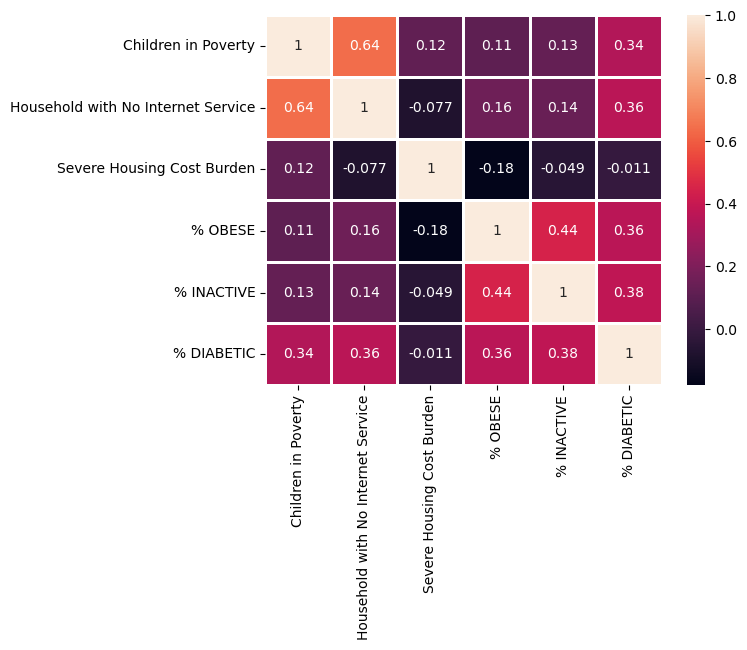

In [25]:
sns.heatmap(data_no_outliers[numerical_features].corr(), annot = True, linewidths = 2)

plt.show()

## Statistical Tests

In [26]:
data_no_outliers.head()

,Children in Poverty,Household with No Internet Service,Severe Housing Cost Burden,Urban_Rural,% OBESE,% INACTIVE,% DIABETIC
1,7.2,6.2,7.213579,Rural,18.9,16.2,6.8
2,23.2,33.9,6.432749,Rural,19.4,15.0,7.3
4,5.0,12.5,1.583113,Rural,18.3,15.8,6.6
5,28.3,33.7,6.422018,Rural,19.0,16.8,7.9
6,24.5,10.0,5.852417,Rural,18.1,14.3,7.3


### Are Urban and Rural Areas Significantly Different in Terms of % DIABETIC Rates?

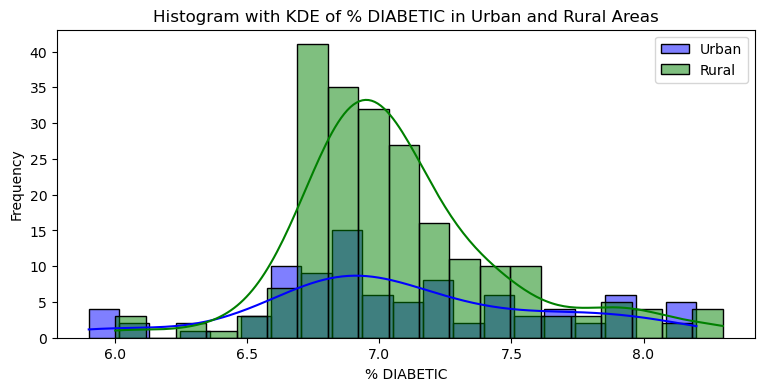

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
urban_diabetic = data_no_outliers[data_no_outliers['Urban_Rural'] == 'Urban']['% DIABETIC']
rural_diabetic = data_no_outliers[data_no_outliers['Urban_Rural'] == 'Rural']['% DIABETIC']

# Create a figure and axis
plt.figure(figsize=(9, 4))

# Plot histograms with KDE
sns.histplot(urban_diabetic, bins=20, kde=True, color='blue', label='Urban', alpha=0.5)
sns.histplot(rural_diabetic, bins=20, kde=True, color='green', label='Rural', alpha=0.5)

# Add labels and title
plt.xlabel('% DIABETIC')
plt.ylabel('Frequency')
plt.title('Histogram with KDE of % DIABETIC in Urban and Rural Areas')

# Add a legend
plt.legend()

# Show the plot
plt.show()


#### Independent t-test

**Null Hypothesis (H0): The mean % DIABETIC in urban areas is equal to the mean % DIABETIC in rural areas.**<br>
**Alternative Hypothesis (Ha): The mean % DIABETIC in urban areas is different from the mean % DIABETIC in rural areas.**

**Independent t-test**<br>
**1. Comparing means of % DIABETIC between two groups: Diabetic and Urban_Rural**

In [28]:
urban_diabetic = data_no_outliers[data_no_outliers['Urban_Rural'] == 'Urban']['% DIABETIC']
rural_diabetic = data_no_outliers[data_no_outliers['Urban_Rural'] == 'Rural']['% DIABETIC']

t_statistic, p_value = stats.ttest_ind(urban_diabetic, rural_diabetic, equal_var=False)

print(f'Test Statistic: {t_statistic:.4f}')
print(f'P-Value: {p_value:.4f}')

alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in % DIABETIC rates between urban and rural areas.')
    
else:
    print('Fail to reject the null hypothesis: There is no significant difference in % DIABETIC rates between urban and rural areas.')
    

Test Statistic: 0.0783
P-Value: 0.9377
Fail to reject the null hypothesis: There is no significant difference in % DIABETIC rates between urban and rural areas.


#### ANOVA (Analysis Of Variance)

In [29]:
category_mapping = {
    'Urban': data_no_outliers[data_no_outliers['Urban_Rural'] == 'Urban']['% DIABETIC'],
    'Rural': data_no_outliers[data_no_outliers['Urban_Rural'] == 'Rural']['% DIABETIC']
}

f_statistic, p_value = stats.f_oneway(*category_mapping.values())

print(f'F-Statistic: {f_statistic:.4f}')
print(f'P-Value: {p_value:.4f}')

alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in % DIABETIC rates among different categories of Urban_Rural.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in % DIABETIC rates among different categories of Urban_Rural.')


F-Statistic: 0.0078
P-Value: 0.9295
Fail to reject the null hypothesis: There is no significant difference in % DIABETIC rates among different categories of Urban_Rural.


#### Post hoc test

In [30]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data_no_outliers['% DIABETIC'], data_no_outliers['Urban_Rural'])

# Perform Tukey's HSD test
tukey_results = mc.tukeyhsd()

# Display the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Rural  Urban   0.0049 0.9295 -0.1035 0.1132  False
---------------------------------------------------


### Does the Presence of 'Severe Housing Cost Burden' Impact % DIABETIC Rates?

**Null Hypothesis (H0): There is no significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'**<br>
**Alternative Hypothesis (Ha): There is a significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.**

In [31]:
correlation_coefficient, p_value = stats.ttest_ind(data_no_outliers['Severe Housing Cost Burden'], data_no_outliers['% DIABETIC'])

print("T-test Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.")


T-test Coefficient: 11.915791525934642
P-Value: 1.3003137353156e-29
Reject the null hypothesis: There is a significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.


### Is There a Relationship Between 'Children in Poverty' and % DIABETIC Rates?

**Null Hypothesis (H0): There is no relationship between 'Children in Poverty' and % DIABETIC rates.**<br>
**Alternative Hypothesis (Ha): There is a relationship between 'Children in Poverty' and % DIABETIC rates.**

In [32]:
correlation_coefficient, p_value = stats.ttest_ind(data_no_outliers['Children in Poverty'], data_no_outliers['% DIABETIC'])

print(f'T-test: {correlation_coefficient:.4f}')
print(f'P-Value: {p_value:.4f}')

alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant relationship between Children in Poverty and % DIABETIC rates.')
else:
    print('Fail to reject the null hypothesis: There is no significant relationship between Children in Poverty and % DIABETIC rates.')

T-test: 28.8327
P-Value: 0.0000
Reject the null hypothesis: There is a significant relationship between Children in Poverty and % DIABETIC rates.


### Does the Presence of 'Household with No Internet Service' Impact % DIABETIC Rates?

In [33]:
correlation_coefficient, p_value = stats.ttest_ind(data_no_outliers['Household with No Internet Service'], data_no_outliers['% DIABETIC'])

print("T-test Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.")


T-test Coefficient: 32.237619458161305
P-Value: 1.7005261218899945e-134
Reject the null hypothesis: There is a significant relationship between 'Severe Housing Cost Burden' and '% DIABETIC Rates'.


In [34]:
data_no_outliers = pd.get_dummies(data_no_outliers, columns=['Urban_Rural'], drop_first = True)
data_no_outliers.head()

,Children in Poverty,Household with No Internet Service,Severe Housing Cost Burden,% OBESE,% INACTIVE,% DIABETIC,Urban_Rural_Urban
1,7.2,6.2,7.213579,18.9,16.2,6.8,False
2,23.2,33.9,6.432749,19.4,15.0,7.3,False
4,5.0,12.5,1.583113,18.3,15.8,6.6,False
5,28.3,33.7,6.422018,19.0,16.8,7.9,False
6,24.5,10.0,5.852417,18.1,14.3,7.3,False


## Multiple Linear Regression (All Features economic factors and others)

### Splitting the data

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_no_outliers.drop(['% DIABETIC'], axis = 1), 
                                                    data_no_outliers['% DIABETIC'], random_state = 42, test_size = 0.3)

### Feature Scaling

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

print("R squared: {}".format(r2_score(y_true = y_train, y_pred = y_pred)))

R squared: 0.298555387237608


### Mean of residuals

In [38]:
residuals = y_train.values - y_pred

mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -6.344131569286609e-16


**Mean is close to zero, So we are good.**

### Check for heteroscedasticity

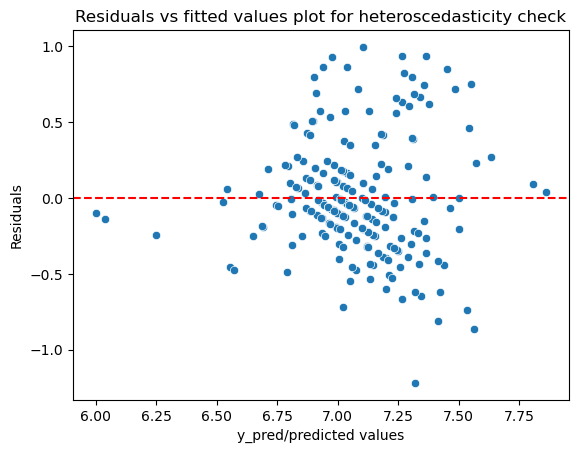

In [39]:
p = sns.scatterplot(x = y_pred, y = residuals)

plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.axhline(0, linestyle = '--', color = 'r')
p = plt.title('Residuals vs fitted values plot for heteroscedasticity check')

### Breusch-Pagan Test

**Null Hypothesis (H0): There is no heteroscedasticity in the regression model.**<br>
**Alternative Hypothesis (H1): There is heteroscedasticity in the regression model.**

In [40]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, sm.add_constant(X_train))

print(f"LM Statistic: {lm}")
print(f"LM p-value: {lm_p_value}")
print(f"F-Statistic: {fvalue}")
print(f"F p-value: {f_p_value}")

if lm_p_value < 0.05 or f_p_value < 0.05:
    print("Heteroscedasticity detected: Reject the null hypothesis")
else:
    print("No evidence of heteroscedasticity: Fail to reject the null hypothesis")

LM Statistic: 26.563792439785495
LM p-value: 0.00017474770924198223
F-Statistic: 4.882121668477975
F p-value: 0.00010796886100479344
Heteroscedasticity detected: Reject the null hypothesis


### Check for Normality of error terms/residuals

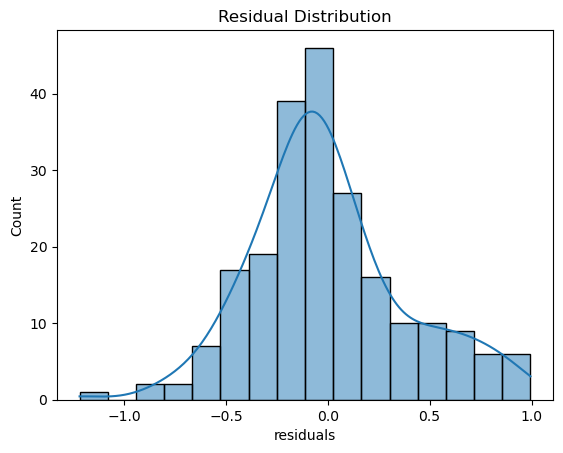

In [41]:
sns.histplot(residuals,kde=True)

plt.xlabel('residuals')
plt.title('Residual Distribution')

plt.show()

## Multiple Linear Regression (with only economic factors)

In [42]:
# independent_vars = ['Severe Housing Cost Burden', 'Children in Poverty', 'Household with No Internet Service', 'Urban_Rural']
independent_vars = ['Severe Housing Cost Burden', 'Children in Poverty', 'Household with No Internet Service']

data_no_outliers['intercept'] = 1
# data_no_outliers['Urban_Rural'] = data_no_outliers['Urban_Rural'].astype('category')
# data_no_outliers = pd.get_dummies(data_no_outliers, prefix='Urban_Rural')

# X = data_no_outliers[['Children in Poverty', 'Household with No Internet Service',
#        'Severe Housing Cost Burden', '% OBESE', '% INACTIVE', '% DIABETIC',
#        'intercept', 'Urban_Rural_Rural', 'Urban_Rural_Urban']]

X = data_no_outliers[['Children in Poverty', 'Household with No Internet Service',
       'intercept']]
y = data_no_outliers['% DIABETIC']

# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

model = sm.OLS(y, X).fit()
summary = model.summary()

print(summary)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.151
Model:                            OLS   Adj. R-squared (uncentered):              0.146
Method:                 Least Squares   F-statistic:                              27.39
Date:                Sun, 08 Oct 2023   Prob (F-statistic):                    1.12e-11
Time:                        17:18:27   Log-Likelihood:                         -414.50
No. Observations:                 310   AIC:                                      833.0
Df Residuals:                     308   BIC:                                      840.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/neereshkumarperla/miniconda3/envs/machine-learning-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [43]:
# independent_vars = ['Severe Housing Cost Burden', 'Children in Poverty', 'Household with No Internet Service', 'Urban_Rural']
independent_vars = ['Severe Housing Cost Burden', 'Children in Poverty', 'Household with No Internet Service']

data_no_outliers['intercept'] = 1
# data_no_outliers['Urban_Rural'] = data_no_outliers['Urban_Rural'].astype('category')
# data_no_outliers = pd.get_dummies(data_no_outliers, prefix='Urban_Rural')

# X = data_no_outliers[['Children in Poverty', 'Household with No Internet Service',
#        'Severe Housing Cost Burden', '% OBESE', '% INACTIVE', '% DIABETIC',
#        'intercept', 'Urban_Rural_Rural', 'Urban_Rural_Urban']]

X = data_no_outliers[['% OBESE', '% INACTIVE', 'intercept']]
y = data_no_outliers['% DIABETIC']

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

model = sm.OLS(y, X).fit()
summary = model.summary()

print(summary)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.185
Method:                 Least Squares   F-statistic:                              36.25
Date:                Sun, 08 Oct 2023   Prob (F-statistic):                    7.29e-15
Time:                        17:18:28   Log-Likelihood:                         -407.11
No. Observations:                 310   AIC:                                      818.2
Df Residuals:                     308   BIC:                                      825.7
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/neereshkumarperla/miniconda3/envs/machine-learning-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


**1. When considering all features for multiple linear regression, 29.8% variation in % DIABETIC can be explained by all the features.**<br>
**2. With considering the economic features, only 15.1% variation in % DIABETIC can be explained and**<br>
**3. Only 19.1% of the variation in % DIABETIC can be explained by without economic features.**

**We can see an improvement when considering economic features to our model.**